# Predicting Temperature with LSTM Networks
This Notebook does vanilla LSTM prediction on the temperature without CEEMDAN.
Feel free to skip if this comparison is not important.

In [1]:
from functools import lru_cache
from pathlib import Path
from typing import Tuple

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


Load dataset.

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")
filled.describe().T

,count,mean,std,min,25%,50%,75%,max
STN,32354.0,722860.000000,0.000000,722860.0,722860.0,722860.0,722860.0,722860.00
WBAN,32354.0,27460.341411,17746.121157,23119.0,23119.0,23119.0,23119.0,99999.00
TEMP,32354.0,62.576949,11.061889,31.1,53.9,61.5,71.3,105.40
TEMP_COUNT,32354.0,23.368053,2.851843,4.0,24.0,24.0,24.0,24.00
DEWP,32354.0,377.128723,1790.849275,-14.4,37.9,46.5,53.0,9999.90
DEWP_COUNT,32354.0,23.054305,4.409794,0.0,24.0,24.0,24.0,24.00
SLP,32354.0,1108.205622,910.893861,994.3,1012.1,1014.4,1017.6,9999.90
SLP_COUNT,32354.0,18.957223,7.220772,0.0,8.0,24.0,24.0,24.00
STP,32354.0,5616.034051,4517.678520,939.4,960.3,9999.9,9999.9,9999.90
STP_COUNT,32354.0,9.301817,10.872137,0.0,0.0,0.0,24.0,24.00


Specification for the LSTM model, training parameters, and helper functions.

In [3]:
WIDTH = 7
MAX_EPOCHS = 100
N_BATCH = 64
# Features other than the IMF
# "DEWP", , "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MAX", "MIN", "PRCP", "SNDP"
OTHER_FEATURES = []


def build_compile_model() -> tf.keras.Model:
    """Specify and compile a model."""
    input_layer = tf.keras.Input(
        # Enable to use stateful model
        # batch_shape=(N_BATCH, WIDTH, len(OTHER_FEATURES) + 1)
        shape=(WIDTH, len(OTHER_FEATURES) + 1)
    )
    lstm = tf.keras.layers.Dense(
        N_BATCH * WIDTH * (len(OTHER_FEATURES) + 1), activation="tanh"
    )(input_layer)
    # Shape [batch, time, features] => [batch, time, lstm_units]
    lstm = tf.keras.layers.LSTM(
        N_BATCH, return_sequences=True,
        # stateful=True,
        dropout=0., recurrent_dropout=0.3
    )(lstm)
    lstm = tf.keras.layers.LSTM(
        N_BATCH, return_sequences=True,
        # stateful=True,
        dropout=0., recurrent_dropout=0.2
    )(lstm)
    # Shape => [batch, time, features]
    lstm = tf.keras.layers.Dense(units=1)(lstm)
    model = tf.keras.Model(inputs=input_layer, outputs=lstm)
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


def fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        mode="min"
    )
    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=0, shuffle = False
    )
    return history

In [4]:
val_performance = {}
performance = {}
save_path_template = None
no_reload = True

Metal device set to: Training TEMP
Apple M1
Validating TEMP
101/101 [==============================] - 0s 4ms/step - loss: 11.4424 - mean_absolute_error: 2.6056
Testing TEMP


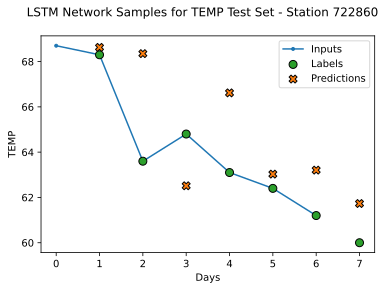

In [5]:
with tf.device("/cpu:0"):
    # Skip the last (trend) IMF
    #for imf_name in (f"IMF_{n}" for n in range(1, len(imfs.T))):
    for imf_name in ["TEMP"]:
        save_path = None
        if save_path_template is not None:
            save_path = Path(save_path_template.format(imf_name=imf_name))
        print(f"Training {imf_name}")
        wide_window = gsod.WindowGenerator(
            df=filled[[imf_name] + OTHER_FEATURES],
            input_width=WIDTH, label_width=WIDTH, shift=1,
            batch_size=N_BATCH, label_columns=[imf_name]
        )
        if save_path is not None and save_path.exists() and not no_reload:
            lstm_model = tf.keras.models.load_model(save_path)
        else:
            lstm_model = build_compile_model()
            fit(lstm_model, wide_window)
        print(f"Validating {imf_name}")
        val_performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.val)
        print(f"Testing {imf_name}")
        performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.test,
                                                         verbose=0)
        wide_window.plot(model=lstm_model, max_subplots=1, plot_col=imf_name,
                         dataset="test", network_name="LSTM", station_name=STATION)
        if save_path is not None:
            lstm_model.save(save_path)
        tf.keras.backend.clear_session()

In [7]:
p=lstm_model.predict(gsod.sliding_window(filled["TEMP"], 7).reshape(-1,7,1))

Text(0, -50, 'MSE: 1.171090470407542\nRMSE: 1.4213609149609143')

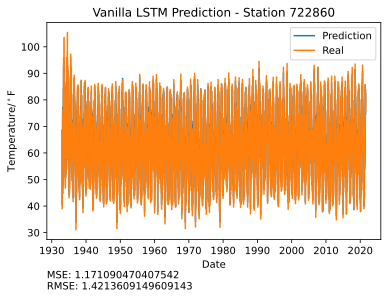

In [ ]:
plt.plot(filled.index[6:], p[:,-1,-1], label="Prediction")
plt.plot(filled["TEMP"], label="Real")
error = filled["TEMP"][6:] - p[:,-1,-1]
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.legend()
plt.title(f"Vanilla LSTM Prediction - Station {STATION}")
plt.annotate(f"MSE: {np.average(np.abs(error))}\nRMSE: {np.average(error ** 2) ** 0.5}", (0, -50), xycoords="axes points")